In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from lifelines import KaplanMeierFitter
from matplotlib import rcParams

sns.set_theme(style="whitegrid")  # or "ticks" if you prefer less grid
rcParams.update(
    {
        "font.family": "sans-serif",
        "font.size": 10,
        "axes.labelsize": 12,
        "axes.labelweight": "bold",
        "axes.titlesize": 12,
        "legend.fontsize": 10,
        # "axes.linewidth": 0.8,
        # "grid.linewidth": 0.6,
        "savefig.dpi": 300,
    }
)

# Load results
df = pd.read_csv("../results/runs/final/greedy_budget.csv")

# Filter to greedy strategy
greedy = df[df["strategy"] == "greedy"].copy()

# For unsolved boards, set to max budget (censored observations)
MAX_BUDGET = 20000
greedy.loc[greedy["solved"] == 0, "presses_used"] = MAX_BUDGET

MY_WIDTH = 5.87 * 1.5  # in inches
ratio = 4 / 3  # height/width ratio
MY_HEIGHT = MY_WIDTH / ratio

print(f"Figure size: {MY_WIDTH:.2f} x {MY_HEIGHT:.2f} inches")
# Print in centimeters
print(f"Figure size: {MY_WIDTH * 2.54:.2f} x {MY_HEIGHT * 2.54:.2f} cm")

Figure size: 8.80 x 6.60 inches
Figure size: 22.36 x 16.77 cm


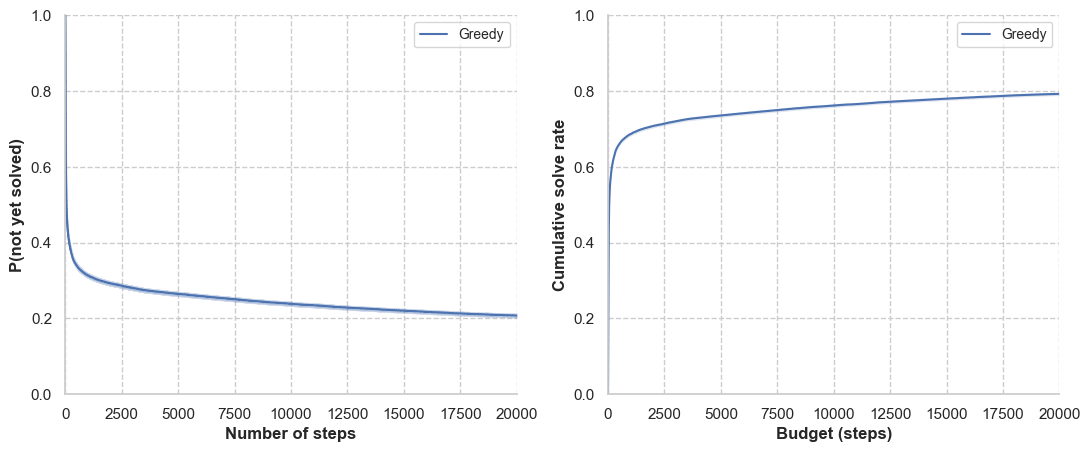

Solve rates at specific budgets:


,budget,solve_rate
0,100,56.0%
1,300,63.4%
2,500,66.0%
3,1000,68.7%
4,2000,70.8%
5,5000,73.5%
6,10000,76.2%
7,20000,79.3%


In [5]:
# Fit Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(
    durations=greedy["presses_used"],
    event_observed=greedy["solved"],
    label="Greedy",
)

# Plot survival curve (probability of NOT yet solving)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(MY_WIDTH * 1.25, MY_HEIGHT * 0.7))

# Left: Survival curve (prob of not solving yet)
kmf.plot_survival_function(ax=ax1, ci_show=True)
ax1.set_xlabel("Number of steps")
ax1.set_ylabel("P(not yet solved)")
ax1.grid(linestyle="--")
ax1.set_ylim(0, 1)

# Right: Cumulative solve rate (1 - survival)
ax2.plot(
    kmf.survival_function_.index,
    1 - kmf.survival_function_.values,
    label="Greedy",
)
ax2.fill_between(
    kmf.confidence_interval_.index,
    1 - kmf.confidence_interval_["Greedy_upper_0.95"],
    1 - kmf.confidence_interval_["Greedy_lower_0.95"],
    alpha=0.2,
)
ax2.legend()
ax2.set_xlabel("Budget (steps)")
ax2.set_ylabel("Cumulative solve rate")
ax2.grid(linestyle="--")
ax2.set_ylim(0, 1)
ax1.set_xlim(0, MAX_BUDGET)
ax2.set_xlim(0, MAX_BUDGET)

sns.despine()
plt.tight_layout()
plt.savefig("../results/plots/greedy_budget_analysis.pdf")
plt.savefig("../results/presentation/plots/greedy_budget_analysis.svg")
plt.show()

# Print key statistics
print("Solve rates at specific budgets:")

budget_data = []
for budget in [100, 300, 500, 1000, 2000, 5000, 10000, 20000]:
    if budget <= MAX_BUDGET:
        # Get survival probability at this budget
        survival_at_budget = kmf.predict(budget)
        solve_rate = 1 - survival_at_budget
        budget_data.append((budget, solve_rate))

# Create DataFrame
budget_df = pd.DataFrame(budget_data, columns=["budget", "solve_rate"])
budget_df["solve_rate"] = budget_df["solve_rate"].apply(lambda x: f"{x:.1%}")

budget_df